<h1><font = "blue"> Quora Question pair (Case-study 1) </font></h1>

<b>Problem Statement</b>
1. Identify which questions asked on Quora are duplicates of questions that have already been asked. 
2. This could be useful to instantly provide answers to questions that have already been answered. 
3. We are tasked with predicting whether a pair of questions are duplicates or not. 

<b>Objective and constraints</b>
1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<b>Data overview</b>
<p> 
1. Data will be in a file Train.csv <br>
2. Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
3. Size of Train.csv - 60MB <br>
4. Number of rows in Train.csv = 404,290
</p>

### Importing packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as npx
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

<h3>Reading data and basic stats </h3>

In [2]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Exploratory data analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3>Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

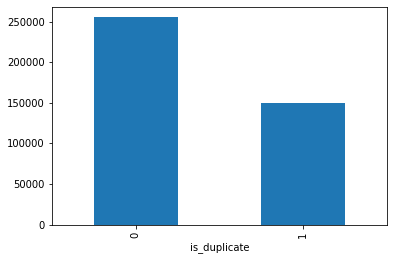

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [7]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3>Number of unique questions </h3>

In [8]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



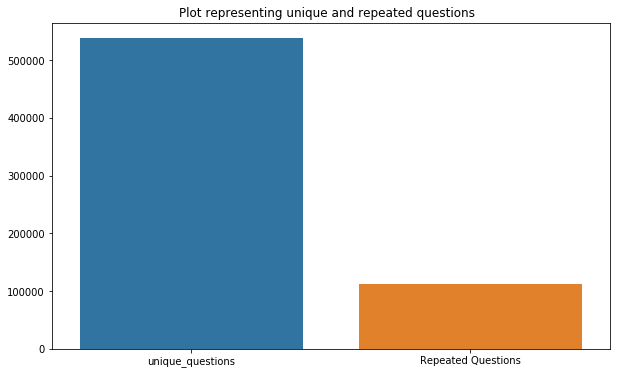

In [9]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>Checking for Duplicates </h3>

In [10]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3>Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



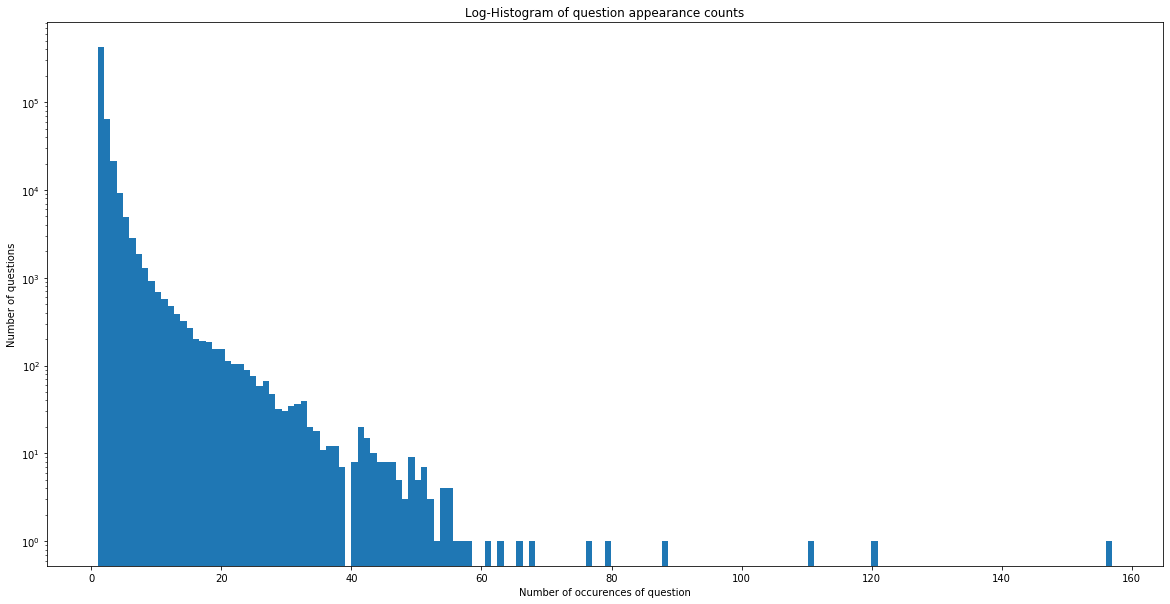

In [11]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3>Checking for NULL values </h3>

In [12]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [13]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [14]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3>Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [15]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4>Feature: word_share </h4>

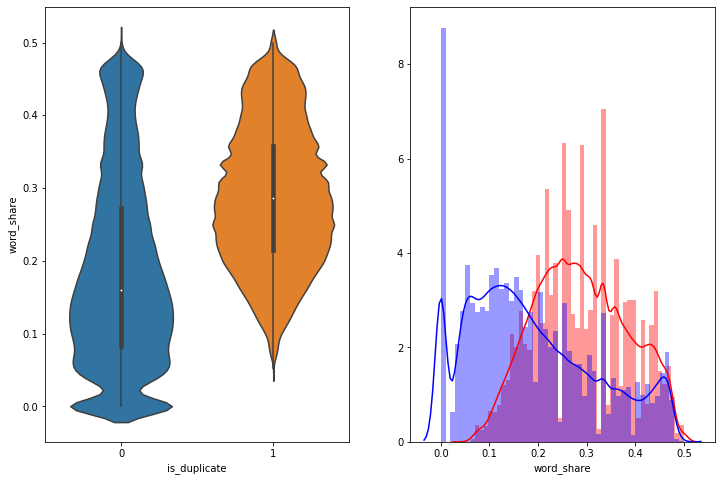

In [16]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4>Feature: word_Common </h4>

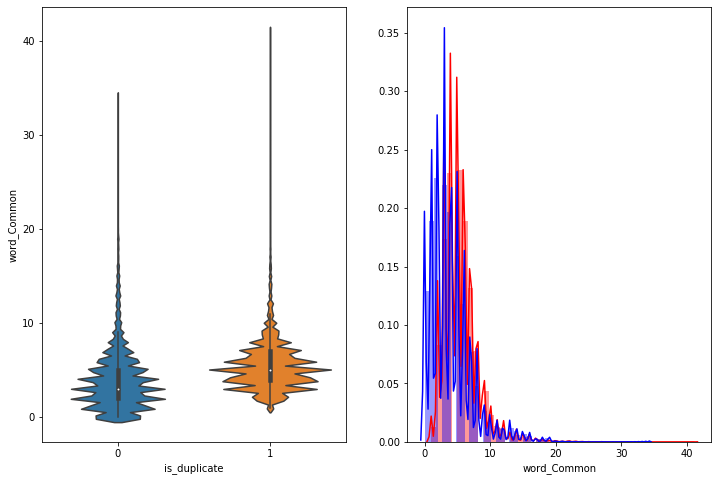

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

### Data preprocessing

#### Preprocessing of Text

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [18]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

### Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [19]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
#import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
#import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [20]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [21]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


# Analysis of extracted features 
_Plotting Word clouds
- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [22]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [23]:
# reading the text files and removing the Stop Words:
from os import path
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt'), encoding="utf-8").read()
textn_w = open(path.join(d, 'train_n.txt'), encoding="utf-8").read()



stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193130


Word Cloud for Duplicate Question pairs


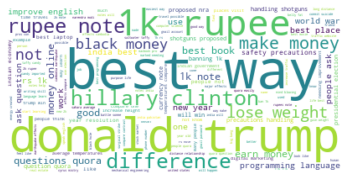

In [24]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


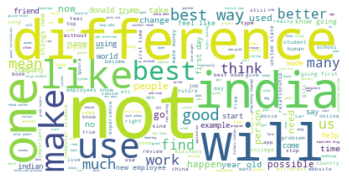

In [25]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] 

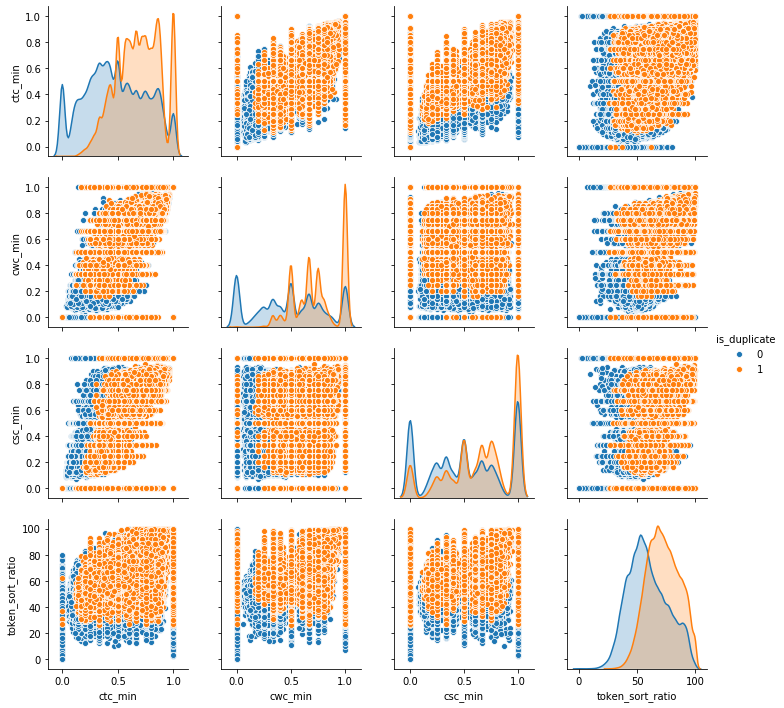

In [26]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

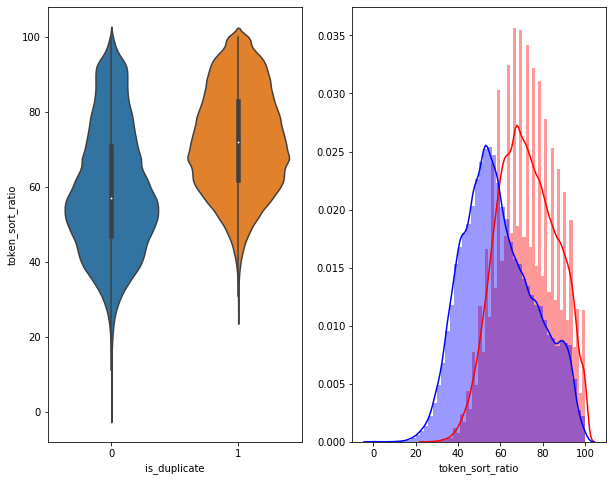

In [27]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

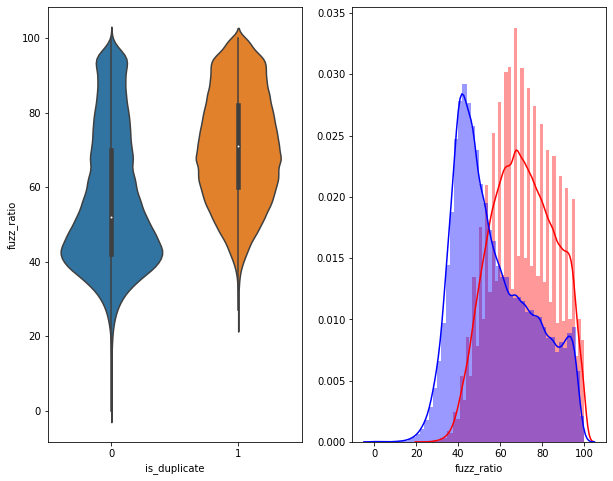

In [28]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

### Visualization 

In [29]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [30]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.008s...
[t-SNE] Computed neighbors for 5000 samples in 0.313s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.215s
[t-SNE] Iteration 50: error = 80.9162369, gradient norm = 0.0427600 (50 iterations in 2.238s)
[t-SNE] Iteration 100: error = 70.3915100, gradient norm = 0.0108003 (50 iterations in 1.644s)
[t-SNE] Iteration 150: error = 68.6126938, gradient norm = 0.0054721 (50 iterations in 1.658s)
[t-SNE] Iteration 200: error = 67.7680206, gradient norm = 0.0042246 (50 iterations in 1.696s)
[t-SNE] Iteration 250: error = 67.2733459, gradient norm = 0.0037275

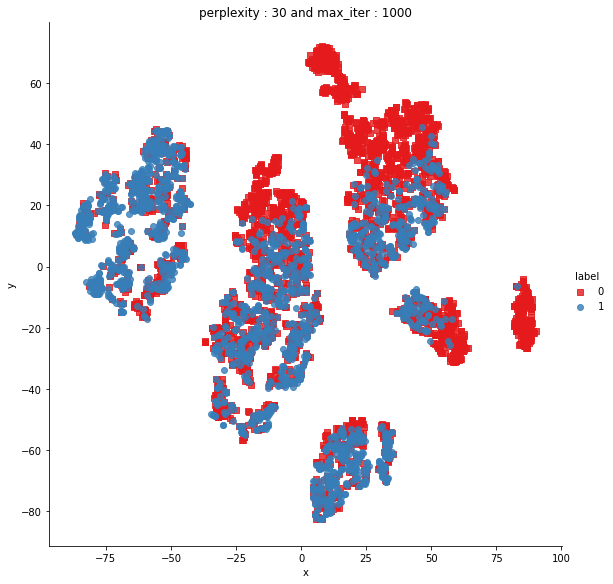

In [31]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [32]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.010s...
[t-SNE] Computed neighbors for 5000 samples in 0.318s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.212s
[t-SNE] Iteration 50: error = 80.3552017, gradient norm = 0.0329941 (50 iterations in 7.791s)
[t-SNE] Iteration 100: error = 69.1100388, gradient norm = 0.0034323 (50 iterations in 4.299s)
[t-SNE] Iteration 150: error = 67.6163483, gradient norm = 0.0017810 (50 iterations in 3.824s)
[t-SNE] Iteration 200: error = 67.0578613, gradient norm = 0.0011246 (50 iterations in 3.806s)
[t-SNE] Iteration 250: error = 66.7297821, gradient norm = 0.0009272

In [33]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

### Reading from "final_features.csv"

In [42]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df1 = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
print(df1.head(3))
print("-"*50)


if os.path.isfile('nlp_features_train.csv'):
    df2 = pd.read_csv('nlp_features_train.csv',encoding='latin-1')

# reference : https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexe
text_data = df1.groupby('id').agg({'freq_qid1':'sum','freq_qid2':'sum', 'q1len':'sum','q2len':'sum','q1_n_words':'sum','q2_n_words':'sum','word_Common':'sum','word_Total':'sum','word_share':'sum','freq_q1+q2':'sum','freq_q1-q2':'sum'})

# join two dataframes(project_data and price_data) in python
# reference : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.m
data = pd.merge(df2, text_data, on='id', how='left')

   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2    

In [4]:
data.to_csv('final_data.csv')

### Random split (70-30)

In [5]:
data = pd.read_csv("final_data.csv")

In [44]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['id','is_duplicate'], axis=1, inplace=True)

In [45]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

In [46]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [47]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283001, 30)
Number of data points in test data : (121287, 30)


In [48]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6307998911664623 Class 1:  0.3692001088335377
---------- Distribution of output variable in test data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


### Tfidf W2V Featurization of question1 and question2

In [11]:
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')


words = []
for i in str(X_train['question1']):
    words.extend(i.split(' '))

for i in str(X_train['question2']):
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)
    
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

Loading Glove Model


1917495it [03:06, 10270.04it/s]


Done. 1917495  words loaded!
all the words in the coupus 1934
the unique words in the coupus 42
The number of words that are present in both glove vectors and our coupus 38 ( 90.476 %)
word 2 vec length 38


In [13]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['question1'].values.astype('U'))
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

train_q1_tfidf_w2v = []
# the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['question1']):
    # for each review/sentence
    vector = np.zeros(300)
    # as word vectors are of zero length
    tf_idf_weight =0
    # num of words with a valid vector in the sentence/review
    sentence = str(sentence)
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word 
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentenc            
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            # gettin            
            vector += (vec * tf_idf)
            # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
            if tf_idf_weight != 0: 
                vector /= tf_idf_weight
                train_q1_tfidf_w2v.append(vector)

test_q1_tfidf_w2v = []
for sentence in tqdm(X_test['question1']): 
    vector = np.zeros(300)
    tf_idf_weight =0
    sentence = str(sentence)
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words): 
            vec = model[word]
                      
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
                      
            vector += (vec * tf_idf)            
            tf_idf_weight += tf_idf    
            if tf_idf_weight != 0:        
                vector /= tf_idf_weight    
                test_q1_tfidf_w2v.append(vector)


100%|██████████████████████████████████████████████████████████████████████| 121287/121287 [00:00<00:00, 302516.37it/s]


In [23]:
q1_train_tfidf_w2v = np.array(train_q1_tfidf_w2v).reshape(-1,1)
q1_test_tfidf_w2v = np.array(test_q1_tfidf_w2v).reshape(-1,1)

In [18]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['question2'].values.astype('U'))
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

train_q2_tfidf_w2v = []
# the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['question2']):
    # for each review/sentence
    vector = np.zeros(300)
    # as word vectors are of zero length
    tf_idf_weight =0
    # num of words with a valid vector in the sentence/review
    sentence = str(sentence)
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word 
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentenc            
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            # gettin            
            vector += (vec * tf_idf)
            # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
            if tf_idf_weight != 0: 
                vector /= tf_idf_weight
                train_q2_tfidf_w2v.append(vector)

test_q2_tfidf_w2v = []
for sentence in tqdm(X_test['question2'].values.astype('U')): 
    vector = np.zeros(300)
    tf_idf_weight =0
    sentence = str(sentence)
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words): 
            vec = model[word]
                      
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
                      
            vector += (vec * tf_idf)            
            tf_idf_weight += tf_idf    
            if tf_idf_weight != 0:        
                vector /= tf_idf_weight    
                test_q1_tfidf_w2v.append(vector)

100%|██████████████████████████████████████████████████████████████████████| 121287/121287 [00:00<00:00, 180833.40it/s]


In [24]:
q2_train_tfidf_w2v = np.array(train_q2_tfidf_w2v).reshape(-1,1)
q2_test_tfidf_w2v = np.array(test_q2_tfidf_w2v).reshape(-1,1)

In [49]:
cwc_min_train = X_train['cwc_min'].values.reshape(-1,1)
cwc_min_test = X_test['cwc_min'].values.reshape(-1,1)

cwc_max_train = X_train['cwc_max'].values.reshape(-1,1)
cwc_max_test = X_test['cwc_max'].values.reshape(-1,1)

csc_min_train = X_train['csc_min'].values.reshape(-1,1)
csc_min_test = X_test['csc_min'].values.reshape(-1,1)

csc_max_train = X_train['csc_max'].values.reshape(-1,1)
csc_max_test = X_test['csc_max'].values.reshape(-1,1)

ctc_min_train = X_train['ctc_min'].values.reshape(-1,1)
ctc_min_test = X_test['ctc_min'].values.reshape(-1,1)

ctc_max_train = X_train['ctc_max'].values.reshape(-1,1)
ctc_max_test = X_test['ctc_max'].values.reshape(-1,1)

last_word_eq_train = X_train['last_word_eq'].values.reshape(-1,1)
last_word_eq_test = X_test['last_word_eq'].values.reshape(-1,1)

first_word_eq_train = X_train['first_word_eq'].values.reshape(-1,1)
first_word_eq_test = X_test['first_word_eq'].values.reshape(-1,1)
  
abs_len_diff_train = X_train['abs_len_diff'].values.reshape(-1,1)
abs_len_diff_test = X_test['abs_len_diff'].values.reshape(-1,1)

mean_len_train = X_train['mean_len'].values.reshape(-1,1)
mean_len_test = X_test['mean_len'].values.reshape(-1,1)

token_set_ratio_train = X_train['token_set_ratio'].values.reshape(-1,1)
token_set_ratio_test = X_test['token_set_ratio'].values.reshape(-1,1)

token_sort_ratio_train = X_train['token_sort_ratio'].values.reshape(-1,1)
token_sort_ratio_test = X_test['token_sort_ratio'].values.reshape(-1,1)

fuzz_ratio_train = X_train['fuzz_ratio'].values.reshape(-1,1)
fuzz_ratio_test = X_test['fuzz_ratio'].values.reshape(-1,1)

fuzz_partial_ratio_train = X_train['fuzz_partial_ratio'].values.reshape(-1,1)
fuzz_partial_ratio_test = X_test['fuzz_partial_ratio'].values.reshape(-1,1)

longest_substr_ratio_train = X_train['longest_substr_ratio'].values.reshape(-1,1)
longest_substr_ratio_test = X_test['longest_substr_ratio'].values.reshape(-1,1)

freq_qid1_train = X_train['freq_qid1'].values.reshape(-1,1)
freq_qid1_test = X_test['freq_qid1'].values.reshape(-1,1)

freq_qid2_train = X_train['freq_qid2'].values.reshape(-1,1)
freq_qid2_test = X_test['freq_qid2'].values.reshape(-1,1)

q1len_train = X_train['q1len'].values.reshape(-1,1)
q1len_test = X_test['q1len'].values.reshape(-1,1)

q2len_train = X_train['q2len'].values.reshape(-1,1)
q2len_test = X_test['q2len'].values.reshape(-1,1)

q1_n_words_train = X_train['q1_n_words'].values.reshape(-1,1)
q1_n_words_test = X_test['q1_n_words'].values.reshape(-1,1)

q2_n_words_train = X_train['q2_n_words'].values.reshape(-1,1)
q2_n_words_test = X_test['q2_n_words'].values.reshape(-1,1)

word_Common_train = X_train['word_Common'].values.reshape(-1,1)
word_Common_test = X_test['word_Common'].values.reshape(-1,1)

word_Total_train = X_train['word_Total'].values.reshape(-1,1)
word_Total_test = X_test['word_Total'].values.reshape(-1,1)

word_share_train = X_train['word_share'].values.reshape(-1,1)
word_share_test = X_test['word_share'].values.reshape(-1,1)

freq_q1_add_q2_train = X_train['freq_q1+q2'].values.reshape(-1,1)
freq_q1_add_q2_test = X_test['freq_q1+q2'].values.reshape(-1,1)

freq_q1_sub_q2_train = X_train['freq_q1-q2'].values.reshape(-1,1)
freq_q1_sub_q2_test = X_test['freq_q1-q2'].values.reshape(-1,1)
 

In [25]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)+++
X_train = hstack((q1_train_tfidf_w2v,q2_train_tfidf_w2v,cwc_min_train,cwc_max_train,csc_min_train,csc_max_train,ctc_min_train,ctc_max_train,last_word_eq_train,first_word_eq_train,abs_len_diff_train,mean_len_train ,token_set_ratio_train,token_sort_ratio_train,fuzz_ratio_train,fuzz_partial_ratio_train,longest_substr_ratio_train,freq_qid1_train,freq_qid2_train,q1len_train,q2len_train,q1_n_words_train,q2_n_words_train,word_Common_train,word_Total_train,word_share_train,freq_q1_add_q2_train ,freq_q1_sub_q2_train)).tocsr()

X_test = hstack((q1_test_tfidf_w2v,q2_test_tfidf_w2v,cwc_min_test,cwc_max_test,csc_min_test,csc_max_test,ctc_min_test,ctc_max_test,last_word_eq_test,first_word_eq_test,abs_len_diff_test,mean_len_test ,token_set_ratio_test,token_sort_ratio_test,fuzz_ratio_test,fuzz_partial_ratio_test,longest_substr_ratio_test,freq_qid1_test,freq_qid2_test,q1len_test,q2len_test,q1_n_words_test,q2_n_words_test,word_Common_test,word_Total_test,word_share_test,freq_q1_add_q2_test ,freq_q1_sub_q2_test)).tocsr()

print('Final matrix')
print(X_train.shape)
print(X_test.shape)

Final matrix
(283002, 28)
(121287, 28)


### Function for confusion matrix

In [26]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h3>Building a random model (Finding worst-case log-loss) </h3>

Log loss on Test Data using Random Model 0.8870880786536802


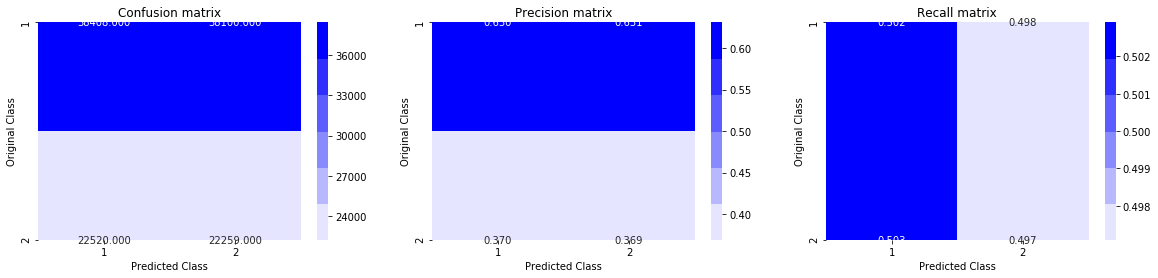

In [27]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### Logistic regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.42668826167841084
For values of alpha =  0.0001 The log loss is: 0.4391130984486006
For values of alpha =  0.001 The log loss is: 0.439644760922563
For values of alpha =  0.01 The log loss is: 0.44991056283395453
For values of alpha =  0.1 The log loss is: 0.4635913445346395
For values of alpha =  1 The log loss is: 0.4938857161564307
For values of alpha =  10 The log loss is: 0.5457278393203181


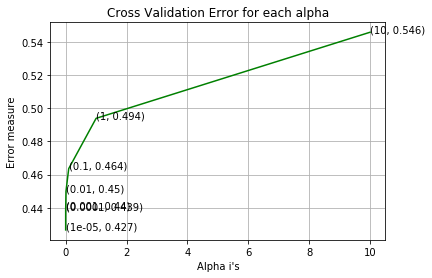

For values of best alpha =  1e-05 The train log loss is: 0.4263713104820307
For values of best alpha =  1e-05 The test log loss is: 0.42668826167841084
Total number of data points : 121287


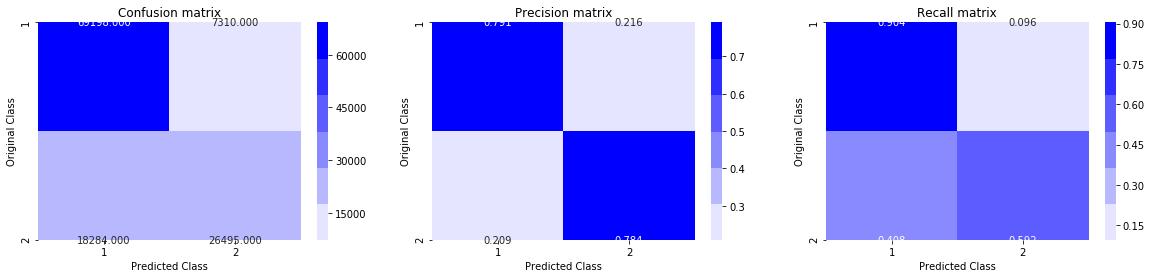

In [28]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.4430080641353851
For values of alpha =  0.0001 The log loss is: 0.4494226497776313
For values of alpha =  0.001 The log loss is: 0.46736297581813974
For values of alpha =  0.01 The log loss is: 0.4873696701218617
For values of alpha =  0.1 The log loss is: 0.4807452985477253
For values of alpha =  1 The log loss is: 0.6081329182197285
For values of alpha =  10 The log loss is: 0.6152977872461357


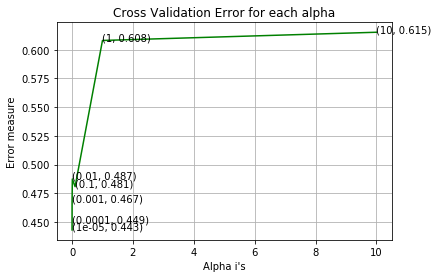

For values of best alpha =  1e-05 The train log loss is: 0.44178160533844807
For values of best alpha =  1e-05 The test log loss is: 0.4430080641353851
Total number of data points : 121287


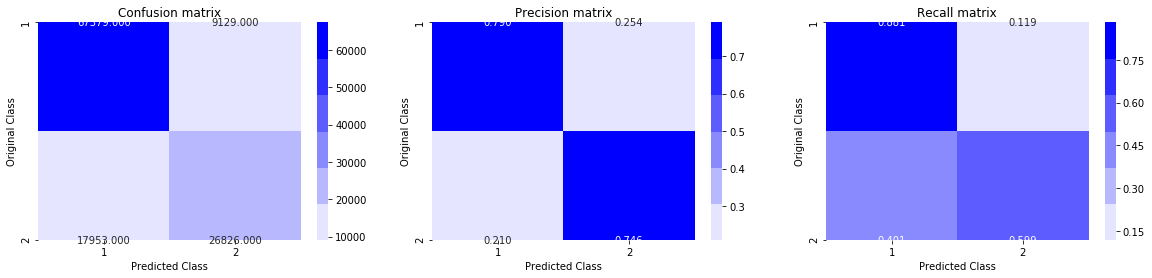

In [29]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### XGBoost

In [30]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.68465	valid-logloss:0.68465
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.614997	valid-logloss:0.615037
[20]	train-logloss:0.564368	valid-logloss:0.564465
[30]	train-logloss:0.526126	valid-logloss:0.526294
[40]	train-logloss:0.497054	valid-logloss:0.497304
[50]	train-logloss:0.474074	valid-logloss:0.474415
[60]	train-logloss:0.455686	valid-logloss:0.456145
[70]	train-logloss:0.440902	valid-logloss:0.441476
[80]	train-logloss:0.428988	valid-logloss:0.42965
[90]	train-logloss:0.419443	valid-logloss:0.420191
[100]	train-logloss:0.411421	valid-logloss:0.412251
[110]	train-logloss:0.404717	valid-logloss:0.405636
[120]	train-logloss:0.399043	valid-logloss:0.400033
[130]	train-logloss:0.394348	valid-logloss:0.395424
[140]	train-logloss:0.39028	valid-logloss:0.391442
[150]	train-logloss:0.386909	valid-logloss:0.388165
[160]	train-logloss:0.383884	val

Total number of data points : 121287


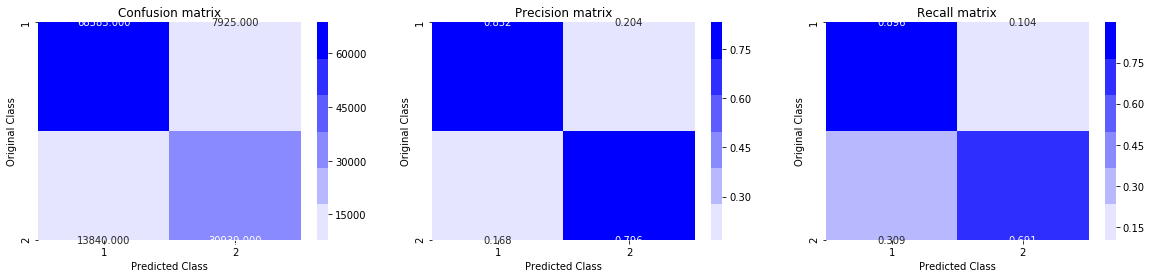

In [31]:
predicted_y = np.array(predict_y > 0.5, dtype = int)

print("Total number of data points :", len(predicted_y))

plot_confusion_matrix(y_test, predicted_y)

<h3><font color="red"> XGboost + Hyperparameter tuning(Random search)</font></h3>

In [32]:
# Import libraries
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

param_grid = {'n_estimators' : [5, 10, 100, 500], 'max_depth' : [2, 5, 8, 10]}

ran = RandomizedSearchCV(estimator = XGBClassifier(objective = 'binary:logistic', eval_metric = 'logloss', eta = 0.02),
                          param_distributions = param_grid)

# fit train sets
ran.fit(X_train, y_train)

# Prediction
y_pred = ran.predict(X_test)

In [33]:
opt_param = ran.best_params_ 
max_score = ran.best_score_ 
print("Optimal hyperParameter:", opt_param)
print("Maximum accuracy:", max_score * 100)

Optimal hyperParameter: {'n_estimators': 500, 'max_depth': 10}
Maximum accuracy: 83.49234281029815


In [35]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 10
params['n_estimators'] = 500

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.682649	valid-logloss:0.682876
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.596655	valid-logloss:0.598951
[20]	train-logloss:0.535398	valid-logloss:0.539535
[30]	train-logloss:0.490203	valid-logloss:0.496049
[40]	train-logloss:0.455711	valid-logloss:0.463151
[50]	train-logloss:0.428668	valid-logloss:0.437622
[60]	train-logloss:0.407513	valid-logloss:0.417866
[70]	train-logloss:0.390699	valid-logloss:0.402414
[80]	train-logloss:0.377047	valid-logloss:0.390095
[90]	train-logloss:0.365754	valid-logloss:0.380111
[100]	train-logloss:0.356527	valid-logloss:0.371969
[110]	train-logloss:0.348912	valid-logloss:0.365378
[120]	train-logloss:0.342578	valid-logloss:0.360049
[130]	train-logloss:0.337488	valid-logloss:0.355917
[140]	train-logloss:0.332963	valid-logloss:0.352388
[150]	train-logloss:0.329121	valid-logloss:0.349534
[160]	train-logloss:0.325763

Total number of data points : 121287


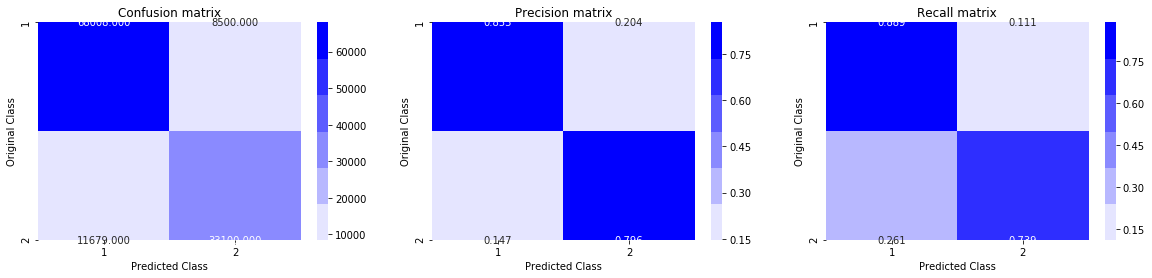

In [36]:
predicted_y = np.array(predict_y > 0.5, dtype = int)

print("Total number of data points :", len(predicted_y))

plot_confusion_matrix(y_test, predicted_y)

<h2><font color="red">******************************************Assignment*********************************************</font></h2>

### Tfidf vectorization of text data (question1 and question2)

#### vectorizing question1

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(min_df=10)

vectorizer_tfidf.fit(X_train['question1'].values.astype('U'))

train_q1_tfidf = vectorizer_tfidf.transform(X_train['question1'].values.astype('U'))

test_q1_tfidf = vectorizer_tfidf.transform(X_test['question1'].values.astype('U'))

print("After vectorizing")
print(train_q1_tfidf.shape)
print(test_q1_tfidf.shape)

After vectorizing
(283001, 12274)
(121287, 12274)


#### Vectorizing question2

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(min_df=10)

vectorizer_tfidf.fit(X_train['question2'].values.astype('U'))

train_q2_tfidf = vectorizer_tfidf.transform(X_train['question2'].values.astype('U'))

test_q2_tfidf = vectorizer_tfidf.transform(X_test['question2'].values.astype('U'))

print("After vectorizing")
print(train_q2_tfidf.shape)
print(test_q2_tfidf.shape)

After vectorizing
(283001, 11815)
(121287, 11815)


In [54]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)+++
X_train = hstack((train_q1_tfidf,train_q2_tfidf,cwc_min_train,cwc_max_train,csc_min_train,csc_max_train,ctc_min_train,ctc_max_train,last_word_eq_train,first_word_eq_train,abs_len_diff_train,mean_len_train ,token_set_ratio_train,token_sort_ratio_train,fuzz_ratio_train,fuzz_partial_ratio_train,longest_substr_ratio_train,freq_qid1_train,freq_qid2_train,q1len_train,q2len_train,q1_n_words_train,q2_n_words_train,word_Common_train,word_Total_train,word_share_train,freq_q1_add_q2_train ,freq_q1_sub_q2_train)).tocsr()

X_test = hstack((test_q1_tfidf,test_q2_tfidf,cwc_min_test,cwc_max_test,csc_min_test,csc_max_test,ctc_min_test,ctc_max_test,last_word_eq_test,first_word_eq_test,abs_len_diff_test,mean_len_test ,token_set_ratio_test,token_sort_ratio_test,fuzz_ratio_test,fuzz_partial_ratio_test,longest_substr_ratio_test,freq_qid1_test,freq_qid2_test,q1len_test,q2len_test,q1_n_words_test,q2_n_words_test,word_Common_test,word_Total_test,word_share_test,freq_q1_add_q2_test ,freq_q1_sub_q2_test)).tocsr()

print('Final matrix')
print(X_train.shape)
print(X_test.shape)

Final matrix
(283001, 24115)
(121287, 24115)


### Logistic regression with text tfidf featurized + Hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.3801617576003351
For values of alpha =  0.0001 The log loss is: 0.39171827739466863
For values of alpha =  0.001 The log loss is: 0.41630345120818635
For values of alpha =  0.01 The log loss is: 0.4482779278080706
For values of alpha =  0.1 The log loss is: 0.45988036604782334
For values of alpha =  1 The log loss is: 0.4937963745716688
For values of alpha =  10 The log loss is: 0.5464389448113088


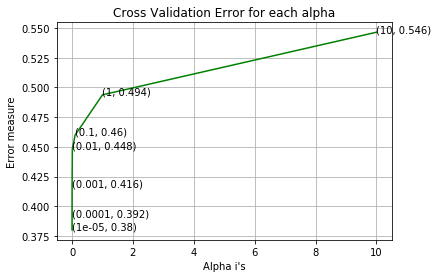

For values of best alpha =  1e-05 The train log loss is: 0.3723948575320608
For values of best alpha =  1e-05 The test log loss is: 0.3801617576003351
Total number of data points : 121287


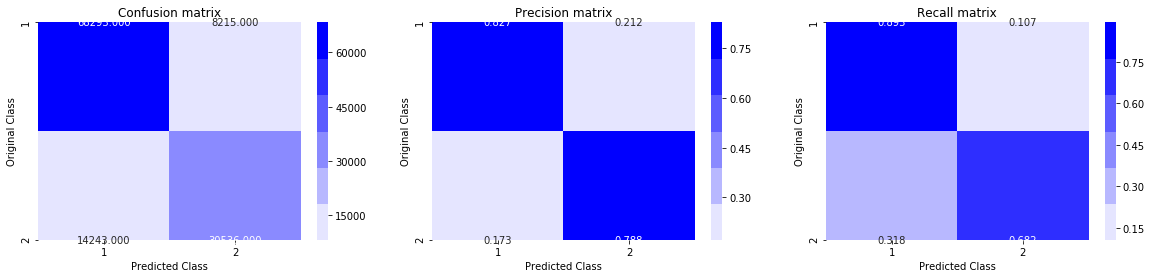

In [55]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Linear SVM with text tfidf featurized + Hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.42916186034919646
For values of alpha =  0.0001 The log loss is: 0.4443487184342462
For values of alpha =  0.001 The log loss is: 0.453762023538856
For values of alpha =  0.01 The log loss is: 0.47396360769012735
For values of alpha =  0.1 The log loss is: 0.4964733909000264
For values of alpha =  1 The log loss is: 0.5792161567797588
For values of alpha =  10 The log loss is: 0.6423260331605957


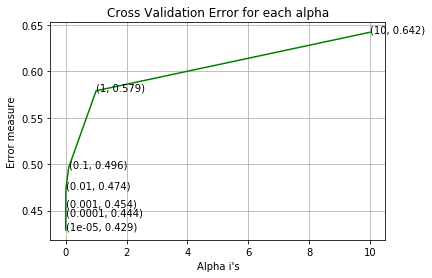

For values of best alpha =  1e-05 The train log loss is: 0.42249244182986223
For values of best alpha =  1e-05 The test log loss is: 0.42916186034919646
Total number of data points : 121287


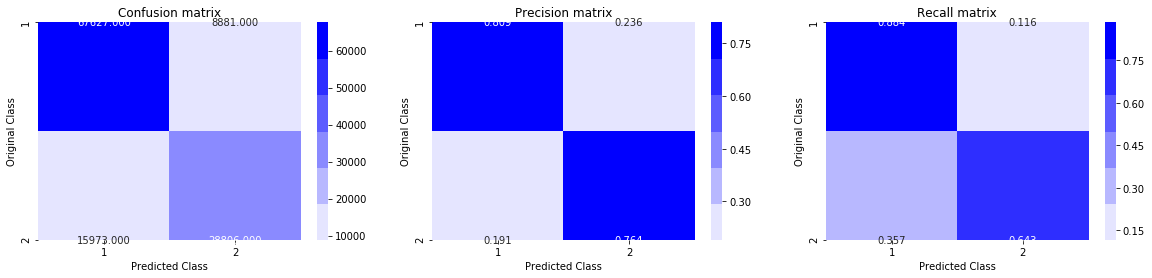

In [56]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

 # Conclusion:

## 1 The base line models
1. Logistic regression with hyperparameter tuning.
2. Linear SVM with hyperparameter tuning
3. XGboost without hyper parameter tuning
4. XGBoost with hyperparameter tuning.

In [57]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = "Conclusion from all the models: Aproach 1"
ptable.field_names = ['Model Name', 'Best parameter','Train loss','Test Log Loss']
ptable.add_row(["Logistic Regression","0.01","0.42","0.42"])
ptable.add_row(["Linear SVM","0.01","0.44","0.44"])
ptable.add_row(["XGBoost","-","0.35","0.35"])
ptable.add_row(["XGBoost","n_estimator=500, max_depth=5","0.29","0.33"])
print(ptable)

+---------------------+------------------------------+------------+---------------+
|      Model Name     |        Best parameter        | Train loss | Test Log Loss |
+---------------------+------------------------------+------------+---------------+
| Logistic Regression |             0.01             |    0.44    |      0.45     |
|      Linear SVM     |             0.01             |    0.44    |      0.44     |
|       XGBoost       |              -               |    0.35    |      0.35     |
|       XGBoost       | n_estimator=500, max_depth=5 |    0.33    |      0.34     |
+---------------------+------------------------------+------------+---------------+


## 2 The base line models (Tfidf vectorized) + hyperparameter tuning
1. Logistic regression with hyperparameter tuning.
2. Linear SVM with hyperparameter tuning

In [59]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = "Conclusion from all the models: Aproach 1"
ptable.field_names = ['Model Name', 'Best parameter','Train loss','Test Log Loss']
ptable.add_row(["Logistic Regression","0.0001","0.37","0.38"])
ptable.add_row(["Linear SVM","1e-5","0.42","0.42"])
print(ptable)

+---------------------+----------------+------------+---------------+
|      Model Name     | Best parameter | Train loss | Test Log Loss |
+---------------------+----------------+------------+---------------+
| Logistic Regression |     0.0001     |    0.37    |      0.38     |
|      Linear SVM     |      1e-5      |    0.42    |      0.42     |
+---------------------+----------------+------------+---------------+


1. XGBoot has performed better than other model
2. Liner SVM has improved when tfidf vectorization has been done.

# Procedure

1. Univariate analysis on given data.
2. Advance feature extraction (NLP and Fuzzy features)
3. Univariate analysis on extracted features
4. Build base line ML models (Logistic regression, linear SVM and XGB without hyperparameter tuning)
5. XGB with hyperparameter tuning
5. Tfidf vectorization of text data (question1 and question2)
5. Build base line ML models (Logistic regression, linear SVM) with the text features tfidf vectorized.
6. Summerized all the models performance using pretty table